In [1]:
import pandas as pd
from pyspi.calculator import Calculator
import numpy as np
from copy import deepcopy
import glob
import os
import random
import neuromaps
from neuromaps.parcellate import Parcellater
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation
from pathlib import Path
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import statsmodels.stats.multitest
from surfplot import Plot
from surfplot.datasets import load_example_data
from neuromaps.datasets import fetch_fslr

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

# Load in the data and filter to directed information (DI) with a Gaussian estimator

In [3]:
data_path = "/Users/abry4213/data/HCP100/"

# Load in all the pyspi homotopic res
all_homotopic_res = pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*.csv")])
di_gaussian_homotopic_res = all_homotopic_res.query("SPI=='di_gaussian'")
di_kozachenko_homotopic_res = all_homotopic_res.query("SPI=='di_kozachenko'")

# Compute the mean value for each base_region_to in di_gaussian_homotopic_res
di_gaussian_homotopic_res_mean = (di_gaussian_homotopic_res
                                  .groupby(['Subject', 'base_region_to', 'SPI'])['value'].mean().reset_index()
                                  .groupby("base_region_to")['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"base_region_to": "Base_Region",
                                                   "value": "Mean_DI_Gaussian"}))

di_gaussian_homotopic_res_for_dk = (di_gaussian_homotopic_res
                                  .groupby(["base_region_to", 'hemi_from'])['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"value": "Mean_DI_Gaussian"})
                                    )

## Visualize the mean DI from L--R and R--L in the brain (averaged across hemispheres, first)

In [4]:
# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

# Read in the DK atlas
lh_labels, lh_ctab, lh_names = fs.read_annot(lh_dk)
rh_labels, rh_ctab, rh_names = fs.read_annot(rh_dk)

# Some big endian byte-swapping is needed
lh_labels = lh_labels.byteswap().view(lh_labels.dtype.newbyteorder('='))
rh_labels = rh_labels.byteswap().view(rh_labels.dtype.newbyteorder('='))

# Create a lookup table dataframe
lh_names_df = pd.DataFrame({'Region': lh_names, 'Vertex_Value': range(len(lh_names))}).assign(Region = lambda x: x['Region'].str.decode('utf-8'))
rh_names_df = pd.DataFrame({'Region': rh_names, 'Vertex_Value': range(len(rh_names))}).assign(Region = lambda x: x['Region'].str.decode('utf-8'))

# Convert vertices to a DataFrame
lh_labels_df = pd.DataFrame({'Vertex_Value': lh_labels, 'Vertex_Index': range(len(lh_labels))}).merge(lh_names_df, on='Vertex_Value', how='left')
rh_labels_df = pd.DataFrame({'Vertex_Value': rh_labels, 'Vertex_Index': range(len(rh_labels))}).merge(rh_names_df, on='Vertex_Value', how='left')

# Merge with DI Gaussian homotopic res
lh_labels_df_with_DI = lh_labels_df.merge(di_gaussian_homotopic_res_for_dk.query("hemi_from=='left'"), left_on='Region', right_on='base_region_to', how='left')
rh_labels_df_with_DI = rh_labels_df.merge(di_gaussian_homotopic_res_for_dk.query("hemi_from=='right'"), left_on='Region', right_on='base_region_to', how='left')

In [5]:
%%R -i lh_labels_df_with_DI,rh_labels_df_with_DI,di_gaussian_homotopic_res_mean

library(fsbrain)
library(viridis)

# Define directories
subjects_dir = "~/data/fs/"
github_dir <- "~/github/MEG_functional_connectivity/"

# fsaverage surface
subject_id = 'fsaverage'

### 3D SURFACE PLOTS ###
# DI_on_brain_surf = vis.symmetric.data.on.subject(subjects_dir, vis_subject_id=subject_id, 
#                                                          morph_data_lh=lh_labels_df_with_DI$Mean_DI_Gaussian, 
#                                                          morph_data_rh=rh_labels_df_with_DI$Mean_DI_Gaussian, 
#                                                          bg='sulc_light',
#                                                          makecmap_options = list('colFn'=viridis),
#                                                          surface="inflated", draw_colorbar = T)

# # Export the vis
# export(DI_on_brain_surf, img_only = TRUE, 
#        output_img = glue("../plots/Mean_LR_averaged_DI_on_surf.png"),
#        rglactions = list('shift_hemis_apart'=TRUE,'no_vis'=T))


### 2D GGSEG PLOTS ###

di_gaussian_homotopic_res_mean %>%
  ungroup() %>%
  mutate(label = glue("lh_{Base_Region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = Mean_DI_Gaussian),
        position = "stacked", colour = "black", hemisphere="left",
        linewidth=0.5) +
  theme_void() +
  labs(fill = "Mean DI") +
  theme(plot.title = element_blank(),
        legend.position = "bottom") +
  scale_fill_viridis_c(na.value = "white")
ggsave("../plots/Mean_LR_averaged_DI_ggseg.svg", width = 4, height = 3)

Joining with `by = join_by(label)`


Loading required package: viridisLite
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


## Plot the overall distribution of Gaussian DI values in each brain region, using a raincloud plot

`summarise()` has grouped output by 'Subject'. You can override using the
`.groups` argument.


/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


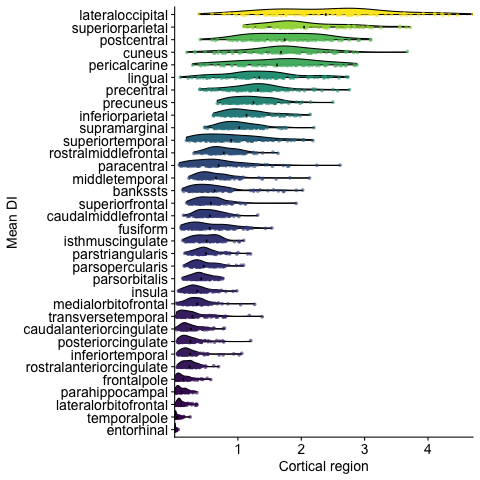

In [6]:
%%R -i di_gaussian_homotopic_res

di_gaussian_homotopic_res %>%
  group_by(Subject, base_region_to) %>%
  summarise(mean_DI = mean(value, na.rm=T)) %>%
  ungroup() %>%
  group_by(base_region_to) %>%
  mutate(mean_region_DI = mean(mean_DI)) %>%
  ungroup() %>%
  mutate(base_region_to = fct_reorder(base_region_to, mean_DI, .fun=mean)) %>%
  ggplot(data=., mapping=aes(x=base_region_to, y=mean_DI, fill=mean_region_DI)) +
  geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
  geom_point(aes(color = mean_region_DI), position = position_jitter(width = 0.075, height=0),
                          size = 1.75, alpha=0.6, stroke=0) +
  stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
          show.legend=FALSE, position = position_dodge(width=1.4))+
  xlab("Mean DI") +
  ylab("Cortical region") +
  scale_y_continuous(expand=c(0,0)) +
  scale_fill_viridis_c(na.value = "white") +
  scale_color_viridis_c(na.value = "white") +
  coord_flip() +
  theme(legend.position="none",
        axis.text = element_text(size=14)) 
# ggsave("../Plots/Subject_wise_LR_averaged_DI_violins.svg", width=6, height=8, dpi=300, units="in")

## Sanity check: is the mean magnitude representative of L-->R and R-->L?

In [7]:
di_gaussian_homotopic_res_for_dk = di_gaussian_homotopic_res_for_dk.assign(hemi_to = lambda x: np.where(x.hemi_from == 'left', 'right', 'left'))

In [8]:
%%R -i di_gaussian_homotopic_res_for_dk

di_gaussian_homotopic_res_for_dk %>%    
    mutate(base_region_to = fct_reorder(base_region_to, Mean_DI_Gaussian, .fun=mean)) %>%
    ggplot(data=., mapping=aes(y=base_region_to, x=Mean_DI_Gaussian)) +
    geom_bar(aes(fill=hemi_from), stat='identity', position='dodge', width=0.7)  +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.8, linewidth=0.4, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    scale_x_continuous(expand=c(0,0)) +
    scale_fill_manual(values=c("left"="#83B2CF", "right"="#245077")) +
    ylab("Cortical region") +
    xlab("Mean DI") +
    theme(legend.position="bottom",
          axis.text = element_text(size=14)) 
ggsave("../Plots/Mean_DI_Gaussian_homotopic_two_directions_bars.svg", width=6, height=8, dpi=300, units="in")

## Is the magnitude of Gaussian DI across brain regions tied to (1) Euclidean distance between the two regions and/or (2) the number of streamlines between those two regions on average?

### Calculate Euclidean, geodesic, and fiber connectivity distances between each region--region pair

In [9]:
# Read in brain region lookup table
brain_region_info = pd.read_csv("../Brain_Region_Info.csv")
fsaverage_data_base_path = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage"

all_centroid_res_list = []
for hemi in ["lh", "rh"]:

    # Load annotation file (parcellation)
    annot_path = f"{fsaverage_data_base_path}/{hemi}.aparc.annot"
    labels, ctab, names = fs.read_annot(annot_path)

    # Load label file (vertex coordinates)
    label_path = f"{fsaverage_data_base_path}/{hemi}.aparc.label"
    vertices = fs.read_label(label_path)

    # Load the FreeSurfer surface (to get vertex coordinates)
    pial_path = f"{fsaverage_data_base_path}/{hemi}.pial"
    surf = fs.read_geometry(pial_path)
    coords, faces = surf
    cort = np.sort(fs.read_label(f"{fsaverage_data_base_path}/{hemi}.cortex.label"))

    # Create a dictionary to store centroids
    roi_centroids = {}

    # Compute centroids for each ROI
    for i, roi_name in enumerate(names):
        roi_vertices = np.where(labels == i)[0]  # Get vertex indices in this ROI
        if len(roi_vertices) > 0:
            roi_centroids[roi_name] = coords[roi_vertices].mean(axis=0)  # Mean position

    # Convert centroids to DataFrame
    centroid_df = pd.DataFrame(roi_centroids).T
    centroid_df.columns = ["x", "y", "z"]

    # Convert names to strings, dropping corpuscallosum
    names_dec = [name.decode() for name in names if name.decode() not in ["corpuscallosum"]]

    # If centroid_df has 34 rows, drop 'unknown' from names
    if centroid_df.shape[0] == 34:
        names_dec = [name for name in names_dec if name != "unknown"]

    # Add region names and hemisphere
    centroid_df = (centroid_df.reset_index(drop=True).assign(Base_Region=names_dec, 
                                                             Hemisphere=np.where(hemi == "lh", "Left", "Right"))
                                                     .assign(Brain_Region = lambda x: hemi + '-' + x['Base_Region']))

    # Append to list
    all_centroid_res_list.append(centroid_df)

# Concatenate the results
all_centroid_res = pd.concat(all_centroid_res_list).query("Base_Region != 'unknown'")

# Compute Euclidean distances between all ROI centroids
dist_matrix = cdist(all_centroid_res[['x', 'y', 'z']], all_centroid_res[['x', 'y', 'z']], metric="euclidean")

# Convert to DataFrame
euclidean_dist_df = (pd.DataFrame(dist_matrix, index=all_centroid_res['Brain_Region'], 
                        columns=all_centroid_res['Brain_Region'])
                        .reset_index()
                        .rename(columns={"Brain_Region": "Brain_Region_From"})
                        .melt(id_vars='Brain_Region_From', var_name='Brain_Region_To', value_name='Euclidean_Distance')
                        .query("Brain_Region_From != Brain_Region_To")
                        .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.split('-').str[1],
                                Base_Region_To = lambda x: x['Brain_Region_To'].str.split('-').str[1],
                                Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.split('-').str[0]=='lh', 'Left', 'Right'),
                                Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.split('-').str[0]=='lh', 'Left', 'Right'))
                        )

# Filter to just the homotopic regions
homotopic_euclidean_dist_df = (euclidean_dist_df.query("Base_Region_From == Base_Region_To").drop_duplicates(subset=['Base_Region_To', 'Euclidean_Distance'])
                               .filter(['Base_Region_To', 'Euclidean_Distance'])
                               .rename(columns={"Base_Region_To": "Base_Region",
                                                "Euclidean_Distance": "Value"})
                               .assign(Category = "Microstructure", Description = "Euclidean Distance")
                               )

# Load in the group-averaged connectome data
homotopic_SC_dist_df = (pd.read_csv(f"{data_path}/raw_data/diffusion_MRI/aparc_HCP100_group_avg_SIFT2_consistency_75.csv",
                               header=None, 
                               names=brain_region_info.Brain_Region)
                               .assign(Brain_Region_From=brain_region_info.Brain_Region)
                               .melt(id_vars="Brain_Region_From", var_name="Brain_Region_To", value_name="SC")
                               .assign(log_SC = lambda x: np.where(x['SC'] > 0, np.log(x['SC']), 0))
                               .query("Brain_Region_From != Brain_Region_To")
                               .assign(Base_Region_From = lambda x: x.Brain_Region_From.str.replace('ctx-lh-', ''),
                                       Base_Region_To = lambda x: x.Brain_Region_To.str.replace('ctx-lh-', ''),
                                       Hemi_From = lambda x: np.where(x.Brain_Region_From.str.contains('lh'), 'Left', 'Right'),
                                       Hemi_To = lambda x: np.where(x.Brain_Region_To.str.contains('lh'), 'Left', 'Right'))
                                .assign(Base_Region_From = lambda x: x.Base_Region_From.str.replace('ctx-rh-', ''),
                                        Base_Region_To = lambda x: x.Base_Region_To.str.replace('ctx-rh-', ''))
                               .query("Base_Region_From == Base_Region_To")
                               .rename(columns={"Base_Region_From": "Base_Region"})
                               .drop_duplicates(subset=['Base_Region', 'SC', 'log_SC'])
                               .filter(['Base_Region', 'log_SC'])
                               .rename(columns={"log_SC": "Value"})
                               .assign(Category = "Microstructure", Description = "Log-SC")
)

# Merge the results
structural_data = pd.concat([homotopic_euclidean_dist_df, homotopic_SC_dist_df]).merge(di_gaussian_homotopic_res_mean, on="Base_Region", how="left")

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 4: The following

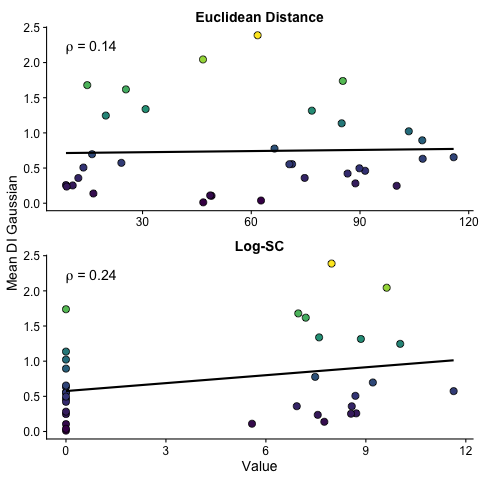

In [47]:
%%R -i structural_data

structural_data %>% 
    filter(Description %in% c("Euclidean Distance", "Log-SC")) %>%
    ggplot(aes(x=Value, y=Mean_DI_Gaussian, fill=Mean_DI_Gaussian)) +
    geom_point(color='black', shape=21, size=3) +
    scale_fill_viridis_c() +
    geom_smooth(method="lm", se=FALSE, color='black') +
    facet_wrap(. ~ Description, scales="free", ncol=1) +
    theme(legend.position="none") +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
    xlab("Value") +
    ylab("Mean DI Gaussian") +
    theme(strip.background = element_blank(),
          strip.text = element_text(face='bold', size=14))

# ggsave("../Plots/Mean_DI_magnitude_vs_physical_distance.svg", width=2.7, height=5, dpi=300, units="in")

## Other functional/structural annotations to consider

In [36]:
# Read in brain region lookup table
brain_region_info = pd.read_csv("../Brain_Region_Info.csv")

# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

if not os.path.exists("hierarchy_dk_neuromaps_res.csv"):
    nm_atlas_df = pd.read_csv('hierarchy_neuromaps_atlases.csv')

    # Convert the DK atlas to gifti format
    dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
    dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

    # Fit a Parcellator object
    parc = Parcellater(dk_gifti, 'fsaverage', resampling_target='parcellation')

    # Loop through each atlas, extract the values in Desikan-Killiany space, and create a dataframe
    all_dk_neuromaps_res_list = []
    for i, row in nm_atlas_df.iterrows():
        this_row_category = row['Category']
        this_row_desc = row['Description']
        source, desc, space, den = row['Filename'].split('-')

        try:
            print(f"Fetching {source} {desc} {space} {den}")
            this_atlas_data = fetch_annotation(source=source, desc=desc, space=space, 
                                                den=den, data_dir=Path("/Users/abry4213/neuromaps-data"))
            
            # Extract this atlas' values in Desikan-Killiany space
            parc_iter = deepcopy(parc)
            this_atlas_data_in_dk = parc_iter.fit_transform(this_atlas_data, space)

            # Create a dataframe
            this_atlas_data_in_dk_df = pd.DataFrame({'Category': this_row_category,
                                                        'Description': this_row_desc,
                                                        'Region_Index': range(len(this_atlas_data_in_dk)),
                                                        'Value': this_atlas_data_in_dk}).merge(brain_region_info, on="Region_Index")
            
            # Append to the list
            all_dk_neuromaps_res_list.append(this_atlas_data_in_dk_df)
        
        except Exception as e:
            print(f"Error parcellating {source} {desc} {space} {den}: {e}")
            continue
        
    # Concatenate all the dataframes
    hierarchy_dk_neuromaps_res = pd.concat(all_dk_neuromaps_res_list)

    # Save the results
    hierarchy_dk_neuromaps_res.to_csv("hierarchy_dk_neuromaps_res.csv", index=False)

else:
    hierarchy_dk_neuromaps_res = pd.read_csv("hierarchy_dk_neuromaps_res.csv")

hierarchy_dk_neuromaps_res_hemi_avg = hierarchy_dk_neuromaps_res.groupby(['Category', 'Description', 'Base_Region'])['Value'].mean().reset_index()

In [37]:
# Group by 'Category' and 'Description' and compute the Spearman correlation
spearman_corrs_di_gaussian = (hierarchy_dk_neuromaps_res_hemi_avg
                              .merge(di_gaussian_homotopic_res_mean, on='Base_Region', how='left')
                              .groupby(['Category', 'Description'])
                              .apply(lambda x: spearmanr(x['Value'], x['Mean_DI_Gaussian'])).apply(pd.Series)
                              .reset_index()
                              .assign(SPI = 'di_gaussian'))

# Rename the columns for clarity
spearman_corrs_di_gaussian.columns = ['Category', 'Description', 'Spearman_Correlation', 'p_value', 'SPI']

# Display the results
spearman_corrs_di_gaussian['p_val_BH'] = statsmodels.stats.multitest.multipletests(spearman_corrs_di_gaussian.p_value, method="fdr_bh")[1]

# Filter to significant results
spearman_corrs_di_gaussian_sig = spearman_corrs_di_gaussian.query("p_val_BH < 0.05 & abs(Spearman_Correlation) > 0.5")

# Filter neuromaps data to the significant results
hierarchy_dk_neuromaps_res_hemi_avg_sig = hierarchy_dk_neuromaps_res_hemi_avg.merge(spearman_corrs_di_gaussian_sig, on=['Category', 'Description'], how='inner')


/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_89169/2727061214.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_di_gaussian = (hierarchy_dk_neuromaps_res_hemi_avg


Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


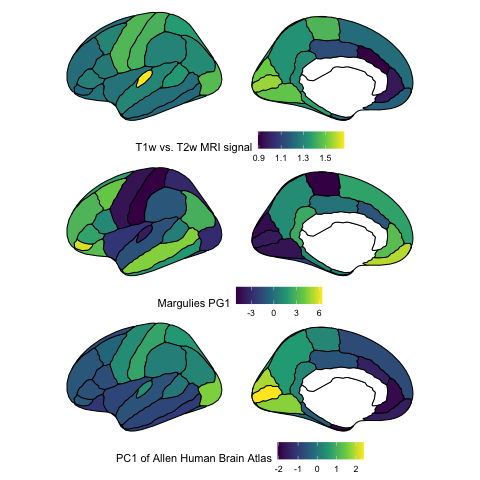

In [39]:
%%R -i hierarchy_dk_neuromaps_res_hemi_avg_sig

all_ggseg_plots_list <- list()

for (desc in unique(hierarchy_dk_neuromaps_res_hemi_avg_sig$Description)) {
      desc_p <- hierarchy_dk_neuromaps_res_hemi_avg_sig %>%
            filter(Description==desc) %>% 
            mutate(label = glue("lh_{Base_Region}")) %>%
            left_join(., as_tibble(dk)) %>%
            ggseg(atlas = dk, mapping = aes(fill = Value),
                  position = "stacked", colour = "black", hemisphere="left",
                  linewidth=0.5) +
            theme_void() +
            labs(fill = desc) +
            theme(plot.title = element_blank(),
                  legend.position = "bottom") +
            scale_fill_viridis_c(na.value = "white")

      all_ggseg_plots_list[[desc]] <- desc_p
}

wrap_plots(all_ggseg_plots_list, ncol=1)
# ggsave("../Plots/neuromaps_with_significant_DI_correlations_ggseg.svg", width=4, height=6, dpi=300, units="in")


In [40]:
hierarchy_neuromaps_vs_di_gaussian_hemi_avg_sig = (hierarchy_dk_neuromaps_res_hemi_avg_sig
                                        .merge(di_gaussian_homotopic_res_mean, on='Base_Region', how='left'))

In [43]:
%%R -i hierarchy_neuromaps_vs_di_gaussian_hemi_avg_sig

hierarchy_neuromaps_vs_di_gaussian_hemi_avg_sig %>% 
    ggplot(data=., mapping=aes(x=Value, y=Mean_DI_Gaussian, fill=Mean_DI_Gaussian)) +
    geom_point(shape=21, color='black', size=3, alpha=0.8) +
    # Facet wrap but repeat axis titles for each facet
    facet_wrap(Description ~ ., scales="free", ncol=1, axis.labels = 'all') +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
    theme(legend.position='none') +
    scale_fill_viridis_c() +
    theme(strip.background = element_blank())
ggsave("../Plots/Hierarchy_maps_with_DI_correlations_scatters.svg", width=2.25, height=6, dpi=300, units="in")

In addition: Warning messages:
1: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 


In [13]:
# ####################################
# # cortical layer data from BigBrainWarp
# ####################################
# # cortical layers
# bigbrainwarppath = '/Users/abry4213/data/BigBrain/spaces/'
# dk_fsaverage_lh = fs.io.read_annot(lh_dk)
# dk_fsaverage_rh = fs.io.read_annot(rh_dk)

# parcellatedData_all = np.zeros((6, 68))
# for i in range(6):
#     lh_file = (bigbrainwarppath + 'tpl-fsaverage/' +
#             'tpl-fsaverage_hemi-L_den-164k_desc-layer%s_thickness.label.gii' % str(i+1))
#     rh_file = (bigbrainwarppath + 'tpl-fsaverage/' +
#             'tpl-fsaverage_hemi-R_den-164k_desc-layer%s_thickness.label.gii' % str(i+1))

#     data_lh = nib.load(lh_file).darrays[0].data
#     data_rh = nib.load(rh_file).darrays[0].data

#     parcelIDs_lh = np.unique(dk_fsaverage_lh[0])
#     parcelIDs_lh = np.delete(parcelIDs_lh, 0)
#     parcelIDs_lh = [i-1 for i in parcelIDs_lh if i != 0]

#     parcellatedData_lh = np.zeros((1, len(parcelIDs_lh)))

#     for IDnum in parcelIDs_lh:
#         idx = np.where(dk_fsaverage_lh[0] == IDnum)[0]
#         parcellatedData_lh[:, IDnum-1] = np.nanmean(data_lh[idx])


#     parcelIDs_rh = np.unique(dk_fsaverage_rh[0])
#     parcelIDs_rh = np.delete(parcelIDs_rh, 0)
#     parcelIDs_rh = [i-1 for i in parcelIDs_rh if i != 0]


#     parcellatedData_rh = np.zeros((1, len(parcelIDs_rh)))

#     for IDnum in parcelIDs_rh:
#         idx = np.where(dk_fsaverage_rh[0] == IDnum)[0]
#         parcellatedData_rh[:, IDnum-1] = np.nanmean(data_rh[idx])

#     parcellatedData = np.hstack((parcellatedData_lh, parcellatedData_rh))

#     parcellatedData_all[i, :] = parcellatedData

# layer_data = parcellatedData_all.T

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
